# Analysis of Algorithms

In [9]:
from load_opb import load_obp_dataset
from linucb import linucb_all

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt


## Importing Data

In [10]:
data = load_obp_dataset()
context = data["context"]
action = data["action"]
reward = data["reward"]
n_actions = data["n_actions"]
context_dim = context.shape[1]
alpha = 1.0


INFO:obp.dataset.real:When `data_path` is not given, this class downloads the small-sized version of Open Bandit Dataset.


## Importing Linear UCB

In [91]:
A = [np.identity(context_dim) for _ in range(n_actions)] #initialized A / V?: design matrix for each action
b = [np.zeros(context_dim) for _ in range(n_actions)] # initialized b: feature vector for each action


results = linucb_all(context, action, reward, A, b, alpha)
for key, value in results.items():
    print(f"{key}: {type(value).__name__}")
# this returns the dictionary from the linucb.py function linucb_all

results_01= linucb_all(context, action, reward, A, b, alpha = 0.1)

results_05 = linucb_all(context, action, reward, A, b, alpha = 0.5)

theta: list
A: list
b: list
chosen_actions: list
true_actions: ndarray
rewards: ndarray
ucb_scores: list


In [12]:
# Print theta estimates

for i, theta in enumerate(results["theta"]):
    print(f"Arm {i} Coefficients: {np.round(theta, 2)}")

# Accuracy or decision match
import matplotlib.pyplot as plt

matches = np.array(results["chosen_actions"]) == np.array(results["true_actions"])
print(f" first few predictions: {results['chosen_actions'][:10]}")
print(f" first few true actions: {results['true_actions'][:10]}")
print(f"Accuracy: {matches.mean() * 100:.2f}%")


Arm 0 Coefficients: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Arm 1 Coefficients: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Arm 2 Coefficients: [ 0.   -0.01 -0.01 -0.    0.   -0.01  0.   -0.    0.    0.   -0.    0.01
  0.02 -0.    0.    0.    0.    0.01 -0.01 -0.  ]
Arm 3 Coefficients: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Arm 4 Coefficients: [ 0.    0.03 -0.01 -0.    0.   -0.   -0.02 -0.02  0.   -0.02 -0.02 -0.01
 -0.02 -0.    0.    0.   -0.    0.    0.02  0.  ]
Arm 5 Coefficients: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Arm 6 Coefficients: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Arm 7 Coefficients: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Arm 8 Coefficients: [-0.   -0.01 -0.01 -0.01  0.   -0.01 -0.01  0.04  0.   -0.   -0.   -0.01
 -0.   -0.    0.   -0.02  0.    0.02  0.   -0.  ]
Arm 9 Coefficients: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

We can observe that we do not have a great accucarcy. However, this might be due to the fact that we calculated the overall accucarcy. Due to the nature of the linear UCB algorithm, the accuracy should get better over time, as we simulte online learning. Let's investigate with a plot:

Cumulative Matches:


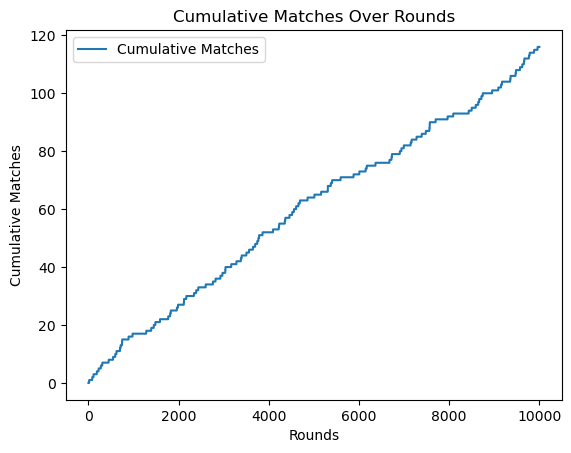

Cumulative Matches: [0 0 0 0 0 0 0 0 0 0]


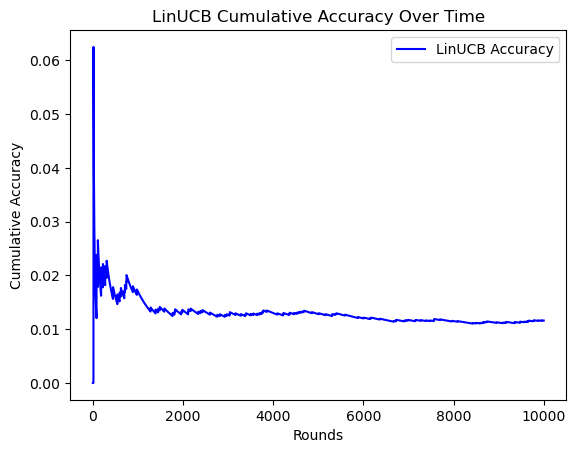

In [13]:

#.figure(figsize=(10, 5))
print("Cumulative Matches:")
plt.plot(np.cumsum(matches), label="Cumulative Matches")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Matches")
plt.title("Cumulative Matches Over Rounds")
plt.legend()
plt.show()

cumulative_matches = np.cumsum(matches)
#print first 10 cumulative matches

print(f"Cumulative Matches: {cumulative_matches[:10]}")
#  calculate accuracy over time

ideal_matches = (np.arange(1, len(matches) + 1))

accuracy_over_time = cumulative_matches / ideal_matches

plt.plot(accuracy_over_time, label='LinUCB Accuracy', color='blue')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Accuracy')
plt.title('LinUCB Cumulative Accuracy Over Time')
plt.legend()
plt.show()

We can see how LinUCB’s selected action rarely matches the action chosen by the logging (random) policy. At first sight, this might seem bad but it is important to remember that we do not model the history action — it is not meaningful in an offline bandit setting. Since the logged actions are random and not necessarily optimal, a low match rate (~1%) simply reflected that LinUCB was learning a different policy, which could be good when we learn the optimal policy. We will check this by investigating the cumulative rewards and compare them with the one of the random policy

## Evaluating the Algorithm

To compare the random policy to the linUCB one, we will use the standard offline bandit evaluation approach and set LinUCB only to receive reward in the rare cases where its selected action matches the one logged by the random policy. However,as a result, most of LinUCB’s potentially good decisions are ignored, leading to a misleadingly low cumulative reward curve. It can be seen in the plot below

To address this, we will implement Inverse Propensity Scoring (IPS), a technique that adjusts for this bias by reweighting observed rewards based on the logging policy's action probabilities. This will allow us to better estimate LinUCB’s true performance despite limited feedback.

In [14]:
print(f"chosen actions: {results['chosen_actions'][:100]}")
print(f"true actions: {results['true_actions'][:100]}")

chosen actions: [0, 1, 2, 3, 4, 0, 5, 6, 7, 8, 2, 0, 1, 1, 9, 10, 3, 11, 12, 13, 14, 15, 4, 16, 17, 18, 7, 5, 19, 20, 21, 22, 23, 6, 24, 8, 25, 10, 26, 27, 9, 12, 11, 14, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 13, 15, 39, 16, 40, 41, 42, 43, 44, 45, 2, 46, 47, 48, 49, 50, 51, 17, 52, 18, 24, 53, 54, 55, 56, 19, 57, 58, 59, 60, 61, 62, 63, 64, 20, 65, 66, 67, 68, 69, 70, 22, 71, 72, 73]
true actions: [14 14 27 48 36  4 70 56 17 55 15 67 45 21 10 10 69 69 43 40 34 68 37 62
 23 79 68 76 16 34 57 29 14 54 31 41 20 73 71 47 78 42 42 74 60 15 43 49
 60 30 22 15 29 77 56 20 63 37 71 13 57 37 31 12 41 36 18 26 29 36  9 11
 50 41 73 33 39 16 37 37 17 43 10 59 64 79 46 22 39 77 55 46 52 12 13 38
  6 14 14 50]


In [15]:
linucb_rewards = np.array(results["rewards"]) * matches

# Optional: convert to list
linucb_rewards = linucb_rewards.tolist()

# Print non-zero rewards
nonzero_rewards = [r for r in linucb_rewards if r > 0]
print(f"Number of valid LinUCB rewards > 0: {len(nonzero_rewards)}")
print(nonzero_rewards[:10])  # first 10


Number of valid LinUCB rewards > 0: 0
[]


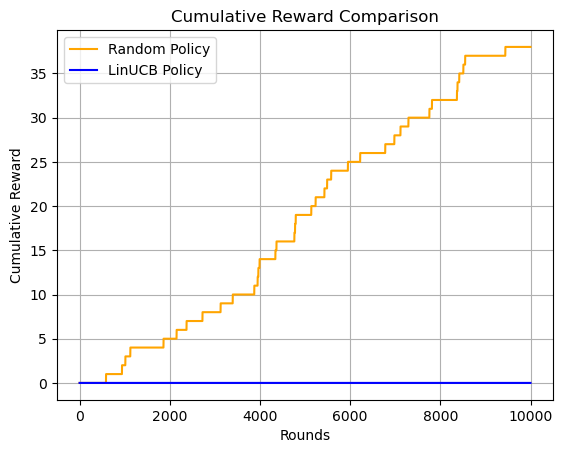

In [16]:

cumulative_random = np.cumsum(data["reward"])

# LinUCB reward
#linucb_reward = np.cumsum(results["rewards"])

plt.plot(cumulative_random, label='Random Policy', color='orange')

plt.plot(linucb_rewards, label='LinUCB Policy', color='blue')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward Comparison')
plt.legend()
plt.grid(True)
plt.show()

### IPS

IPS Weights: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
IPS Estimates: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Total IPS Estimates: 0.0


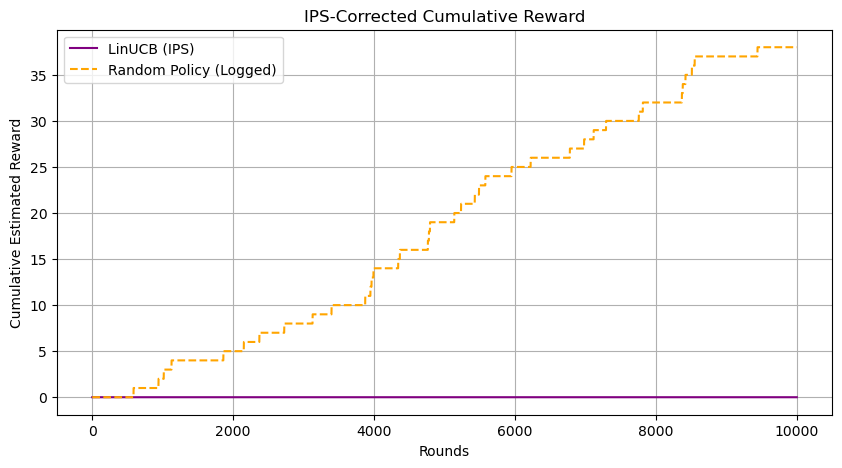

In [17]:
chosen_actions = np.array(results["chosen_actions"])
logged_actions = np.array(data["action"])
rewards = np.array(data["reward"])
pscores = np.array(data["pscore"])

# Indicator: was LinUCB's action equal to the logged one?
matches = chosen_actions == logged_actions

# Apply IPS formula
ips_weights = matches / pscores  # ips_weights = matches / pscores  # (1 / pscore) if match, 0 otherwise
ips_estimates = ips_weights * rewards
print(f"IPS Weights: {ips_weights[:10]}")  # first 10 weights
print(f"IPS Estimates: {ips_estimates[:10]}")  # first 10
print(f"Total IPS Estimates: {ips_estimates.sum()}")
# Cumulative IPS reward over time
cumulative_ips = np.cumsum(ips_estimates)

plt.figure(figsize=(10, 5))
plt.plot(cumulative_ips, label="LinUCB (IPS)", color="purple")
plt.plot(np.cumsum(rewards), label="Random Policy (Logged)", color="orange", linestyle="--")
plt.title("IPS-Corrected Cumulative Reward")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Estimated Reward")
plt.legend()
plt.grid(True)
plt.show()


Again, we do not have any reward for our function:

In our offline evaluation, we observe that LinUCB rarely matches the action selected by the random logging policy, and even when it does, the observed reward is zero. As a result, the Inverse Propensity Scoring (IPS) estimate of LinUCB’s expected reward is also zero. 

However, this should not be interpreted as poor performance. In fact, it indicates that LinUCB is likely learning to avoid the suboptimal actions frequently chosen by the random policy—many of which yield no reward. The problem lies not in the algorithm’s decisions, but in the limitations of offline evaluation: since we only observe rewards for the logged actions, we cannot know the outcomes of the (likely better) actions chosen by LinUCB. This highlights the fundamental challenge of offline bandit evaluation—good policies may appear ineffective simply because their smart choices are not reflected in the logged data.

## Doubly Robust (DR) estimators

To address this limitation, we turn to the Doubly Robust (DR) estimator. DR combines a learned reward model with IPS, allowing us to estimate rewards even when action matches are rare or uninformative. This makes it especially well-suited for our offline evaluation scenario, where observed rewards are sparse and noisy.

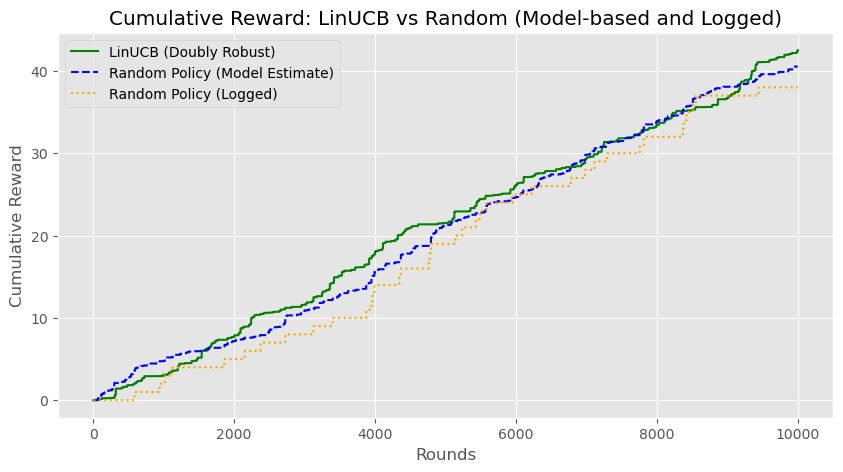

In [63]:
# --- Step 1: Prepare data ---
X_context = data["context"]
a_logged = np.array(data["action"])
r_logged = np.array(data["reward"])
pscore = np.array(data["pscore"])
a_target = np.array(results["chosen_actions"])  # LinUCB's chosen actions

# One-hot encode actions
action_onehot = OneHotEncoder(sparse=False)
a_onehot = action_onehot.fit_transform(a_logged.reshape(-1, 1))

# Feature matrix: [context | one-hot(action)]
X_train = np.hstack([X_context, a_onehot])
y_reward = r_logged

# --- Step 2: Train reward model ---
reward_model = RandomForestRegressor(n_estimators=100, random_state=42)
reward_model.fit(X_train, y_reward)

# --- Step 3: Predict rewards for LinUCB's chosen actions ---
a_target_onehot = action_onehot.transform(a_target.reshape(-1, 1))
X_test = np.hstack([X_context, a_target_onehot])
r_hat = reward_model.predict(X_test)

# -- step: predict reward for logged actions
a_logged_onehot = action_onehot.transform(a_logged.reshape(-1, 1))
X_logged = np.hstack([X_context, a_logged_onehot])
r_hat_random = reward_model.predict(X_logged)

# Cumulative expected reward from the random policy (Direct Method)
cumulative_dm_random = np.cumsum(r_hat_random)

# --- Step 4: Apply Doubly Robust Estimator ---
matches = a_target == a_logged
correction = np.zeros_like(r_logged)
correction[matches] = (r_logged[matches] - r_hat[matches]) / pscore[matches]
dr_estimates = r_hat + correction
cumulative_dr = np.cumsum(dr_estimates)

# --- Step 5: Compare with Random Logging Policy (baseline) ---
cumulative_random = np.cumsum(r_logged)

# --- Step 6: Plot Comparison ---
plt.figure(figsize=(10, 5))
plt.plot(cumulative_dr, label="LinUCB (Doubly Robust)", color="green")
plt.plot(cumulative_dm_random, label="Random Policy (Model Estimate)", color="blue", linestyle="--")
plt.plot(np.cumsum(r_logged), label="Random Policy (Logged)", color="orange", linestyle=":")
plt.title("Cumulative Reward: LinUCB vs Random (Model-based and Logged)")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True)
plt.show()


To make sure our DR estimates make sense, we can also plot them like below.

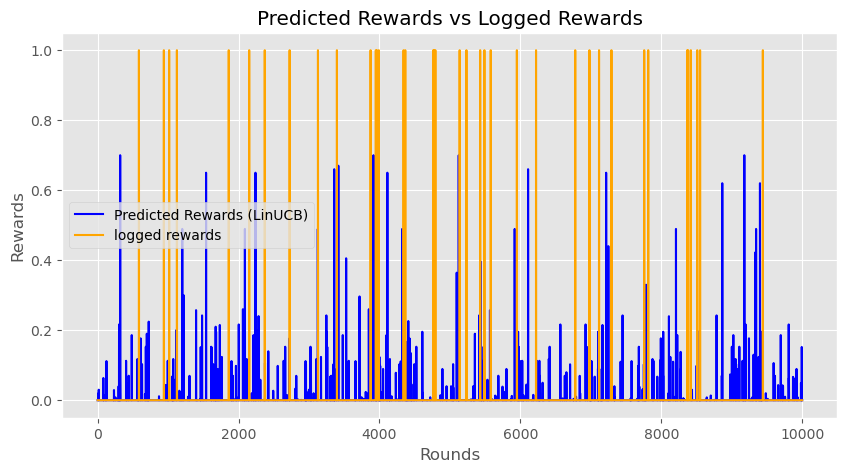

sum of all predicted rewards: 42.513446704448555
sum of all logged rewards: 38


In [68]:
# compare predicted rewards with logged rewards
plt.figure(figsize=(10, 5))
plt.plot(r_hat, label="Predicted Rewards (LinUCB)", color="blue")
plt.plot(rewards, label="logged rewards", color="orange")
plt.title("Predicted Rewards vs Logged Rewards")
plt.xlabel("Rounds")
plt.ylabel("Rewards")
plt.legend()
plt.grid(True)
plt.show()

print(f"sum of all predicted rewards: {np.sum(r_hat)}")
print(f"sum of all logged rewards: {np.sum(rewards)}")

We can see how the DR estimates enable us to do meaningful comparisons of the random policy and the linUCB policy. We plot the logged rewards in yellow, the estimated rewards of the random policy in blue and the estimated rewards of the linUCB in green. 

The green and blue line seem to behave very similiar, altough there could be some slight significant differences so we will run this model multiple times below to get significant results.

Some reasons why the improvement is not large:
1. **Sparse rewards**: Only a small fraction of logged actions have non-zero rewards (clicks), limiting feedback.
2. **Low feedback overlap**: LinUCB rarely matches logged actions, so IPS contributes little (actually not at all as seen above), and DR relies mostly on the reward model.
3. **Context may be weakly informative**: If context features don’t correlate strongly with reward, LinUCB’s advantage is naturally limited.



### Simulating it 100 Times.

In [100]:
average_cumulative_dr = np.zeros(len(data["context"]))
average_cumulative_dm_random = np.zeros(len(data["context"]))

for seed in range(10):
    # Shuffle indices for this seed
    rng = np.random.default_rng(seed)
    indices = rng.permutation(len(data["context"]))

    # Shuffle everything using the same indices
    X_context = data["context"][indices]
    a_logged = np.array(data["action"])[indices]
    r_logged = np.array(data["reward"])[indices]
    pscore = np.array(data["pscore"])[indices]
    a_target = np.array(results["chosen_actions"])[indices]  # ← linUCB chosen actions

    # One-hot encode logged actions
    action_onehot = OneHotEncoder(sparse=False)
    a_logged_1hot = action_onehot.fit_transform(a_logged.reshape(-1, 1))

    # Train reward model on logged data
    X_train = np.hstack([X_context, a_logged_1hot])
    reward_model = RandomForestRegressor(n_estimators=100, random_state=seed)
    reward_model.fit(X_train, r_logged)

    # Predict rewards for LinUCB actions
    a_target_1hot = action_onehot.transform(a_target.reshape(-1, 1))
    X_test = np.hstack([X_context, a_target_1hot])
    r_hat = reward_model.predict(X_test)

    # Predict rewards for logged actions (random policy)
    a_logged_1hot = action_onehot.transform(a_logged.reshape(-1, 1))
    X_logged = np.hstack([X_context, a_logged_1hot])
    r_hat_random = reward_model.predict(X_logged)

    # DR correction
    matches = a_target == a_logged
    correction = np.zeros_like(r_logged)
    correction[matches] = (r_logged[matches] - r_hat[matches]) / pscore[matches]
    dr_estimates = r_hat + correction

    cumulative_dr = np.cumsum(dr_estimates)
    cumulative_dm_random = np.cumsum(r_hat_random)

    # Accumulate
    average_cumulative_dr += cumulative_dr
    average_cumulative_dm_random += cumulative_dm_random

# Average over seeds
average_cumulative_dr /= 10
average_cumulative_dm_random /= 10


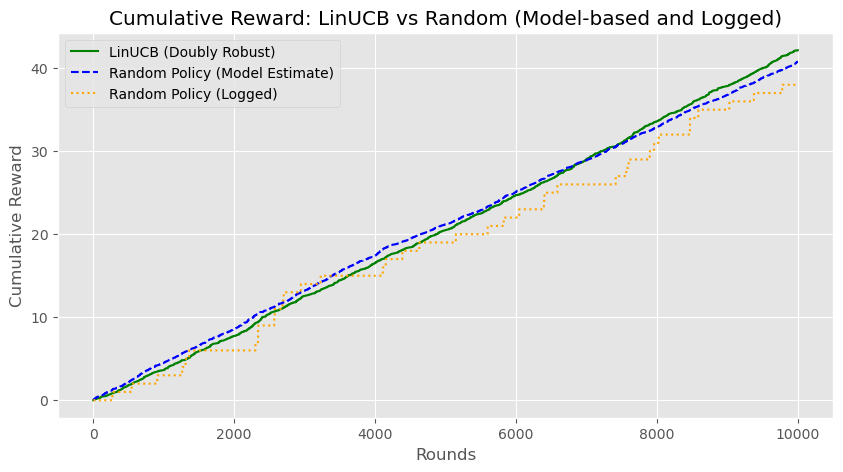

In [101]:

# --- Step 6: Plot Comparison ---
plt.figure(figsize=(10, 5))
plt.plot(average_cumulative_dr, label="LinUCB (Doubly Robust)", color="green")
plt.plot(average_cumulative_dm_random, label="Random Policy (Model Estimate)", color="blue", linestyle="--")
plt.plot(np.cumsum(r_logged), label="Random Policy (Logged)", color="orange", linestyle=":")
plt.title("Cumulative Reward: LinUCB vs Random (Model-based and Logged)")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True)
plt.show()

### LinUCB with different alpha

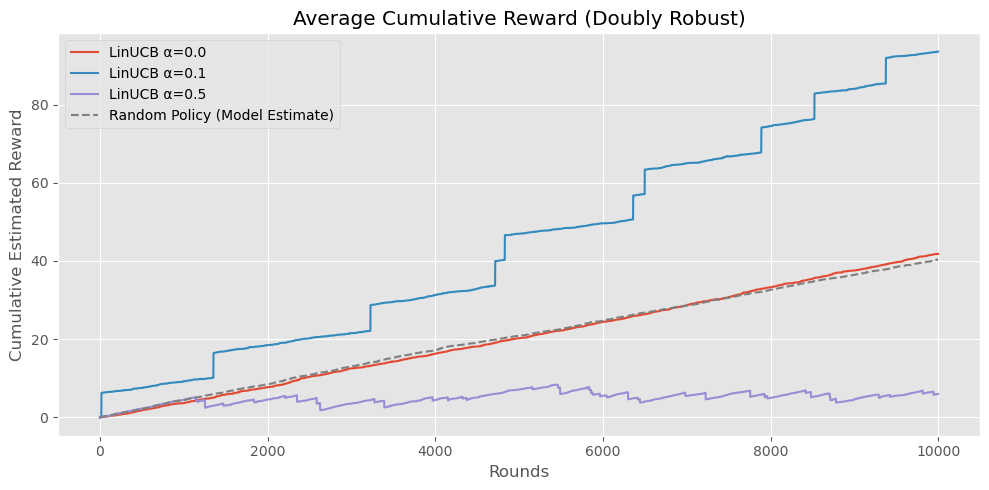

In [95]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np

n_seeds = 10
n_rounds = len(data["context"])
context_dim = data["context"].shape[1]
n_actions = data["n_actions"]

models = {
    "LinUCB α=0.0": results,
    "LinUCB α=0.1": results_01,
    "LinUCB α=0.5": results_05,
}

averages = {label: np.zeros(n_rounds) for label in models}
average_dm_random = np.zeros(n_rounds)

for seed in range(n_seeds):
    # Shuffle everything
    rng = np.random.default_rng(seed)
    idx = rng.permutation(n_rounds)

    X_context = data["context"][idx]
    a_logged = np.array(data["action"])[idx]
    r_logged = np.array(data["reward"])[idx]
    pscore = np.array(data["pscore"])[idx]

    # One-hot encode actions
    action_onehot = OneHotEncoder(sparse=False)
    a_logged_1hot = action_onehot.fit_transform(a_logged.reshape(-1, 1))

    # Train reward model
    X_train = np.hstack([X_context, a_logged_1hot])
    reward_model = RandomForestRegressor(n_estimators=100, random_state=42)
    reward_model.fit(X_train, r_logged)

    # Predict reward for random policy (model-based)
    X_logged = np.hstack([X_context, a_logged_1hot])
    r_hat_random = reward_model.predict(X_logged)
    average_dm_random += np.cumsum(r_hat_random)

    for label, model in models.items():
        a_target = np.array(model["chosen_actions"])[idx]
        a_target_1hot = action_onehot.transform(a_target.reshape(-1, 1))
        X_target = np.hstack([X_context, a_target_1hot])
        r_hat = reward_model.predict(X_target)

        # Apply DR correction
        matches = a_target == a_logged
        correction = np.zeros_like(r_logged)
        correction[matches] = (r_logged[matches] - r_hat[matches]) / pscore[matches]
        dr_estimates = r_hat + correction
        averages[label] += np.cumsum(dr_estimates)

# Normalize over seeds
average_dm_random /= n_seeds
for label in averages:
    averages[label] /= n_seeds

# --- Plot ---
plt.figure(figsize=(10, 5))
for label, curve in averages.items():
    plt.plot(curve, label=label)
plt.plot(average_dm_random, label="Random Policy (Model Estimate)", linestyle="--", color="gray")
plt.title("Average Cumulative Reward (Doubly Robust)")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Estimated Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Compare with official LINUCB

/home/oliver/miniconda3/envs/RL/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/oliver/miniconda3/envs/RL/lib/python3.10/site-packages/obp/ope/meta.py:640: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95.0)` for the same effect.

  sns.barplot(


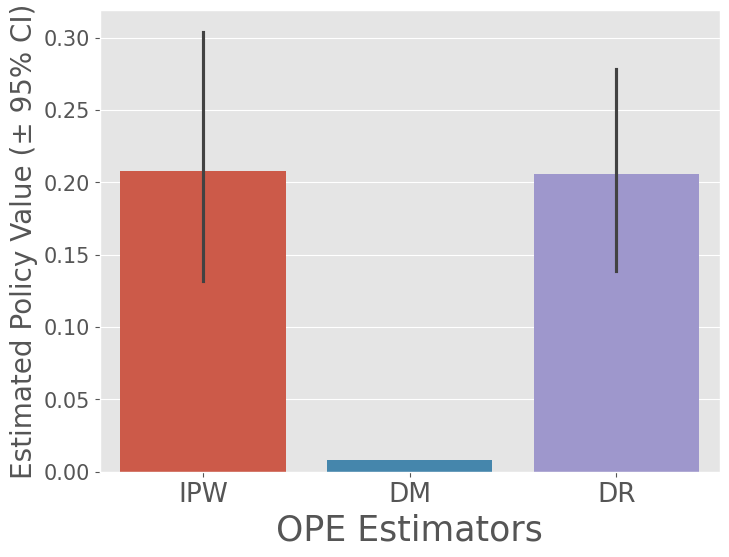

In [80]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from obp.policy import LinUCB
from obp.ope import DoublyRobust, RegressionModel, OffPolicyEvaluation
from obp.policy import IPWLearner


# --- Step 1: Load your logged bandit data ---
X_context = data["context"]                 # shape (n_rounds, d)
a_logged = np.array(data["action"])         # shape (n_rounds,)
r_logged = np.array(data["reward"])         # shape (n_rounds,)
pscore = np.array(data["pscore"])           # shape (n_rounds,)
n_actions = data["n_actions"]

bandit_feedback = {
    "n_rounds": len(X_context),
    "n_actions": n_actions,
    "context": X_context,
    "action": a_logged,
    "reward": r_logged,
    "pscore": pscore,
    "position": np.zeros(len(X_context), dtype=int),  # required by OBP
}


eval_policy = IPWLearner(n_actions=n_actions, base_classifier=LogisticRegression())
eval_policy.fit(
    context=X_context,
    action=a_logged,
    reward=r_logged,
    pscore=pscore
)
action_dist = eval_policy.predict(context=X_context)


regression_model = RegressionModel(
    n_actions=n_actions,
    base_model=LogisticRegression(),
)
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=X_context,
    action=a_logged,
    reward=r_logged
)
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,
    ope_estimators=[IPW(), DM(), DR()]
)
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
)

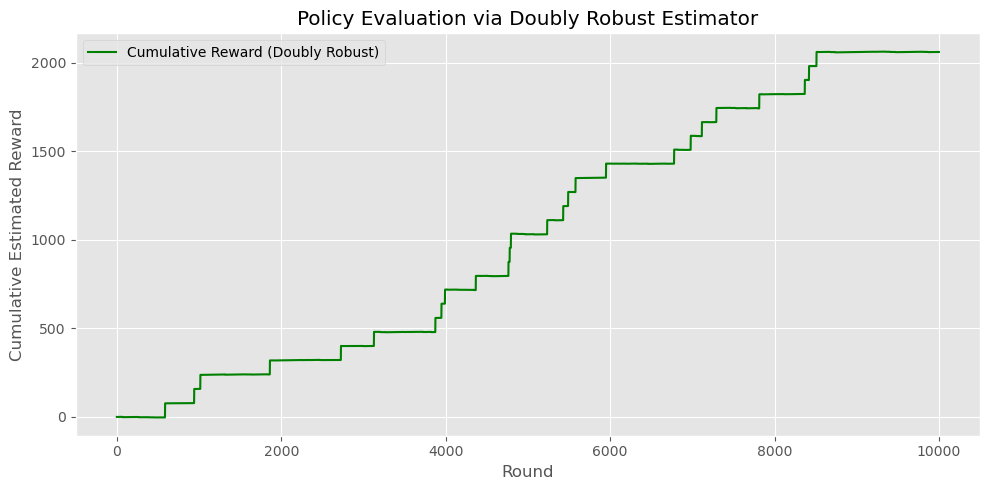

In [81]:
# --- Estimate per-round DR rewards ---
dr_per_round = dr_estimator._estimate_round_rewards(
    reward=bandit_feedback["reward"],
    action=bandit_feedback["action"],
    pscore=bandit_feedback["pscore"],
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    action_dist=action_dist,
    action_by_evaluation_policy=np.argmax(action_dist, axis=1),
    )

# --- Accumulate rewards over time ---
cumulative_dr = np.cumsum(dr_per_round)

# --- Plot cumulative DR reward ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(cumulative_dr, label="Cumulative Reward (Doubly Robust)", color="green")
plt.xlabel("Round")
plt.ylabel("Cumulative Estimated Reward")
plt.title("Policy Evaluation via Doubly Robust Estimator")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
